## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

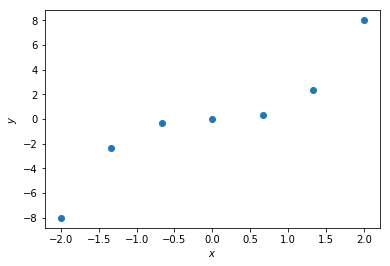

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

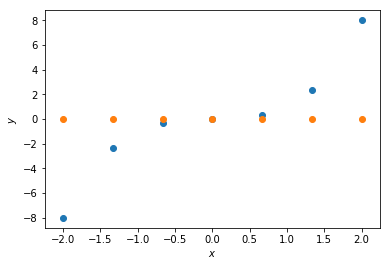

In [3]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.scatter(np.linspace(-2, 2, 7), np.linspace(-2, 2, 7)*0)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

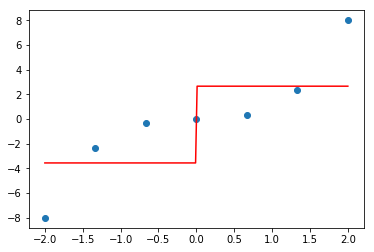

In [4]:
xx = np.linspace(-2, 2, 200)
predictions = [np.mean(y[X < 0]) if x < 0 else np.mean(y[X >= 0])
              for x in xx]

X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y);
plt.plot(xx, predictions, c='red');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

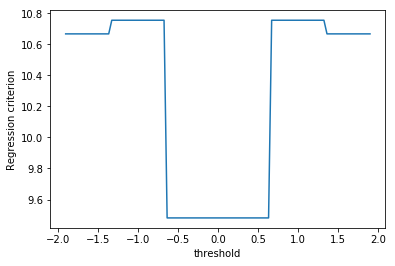

In [5]:
def regression_var_criterion(X, y, t):
    X_left, X_right = X[X < t], X[X >= t]
    y_left, y_right = y[X < t], y[X >= t]
    return np.var(y) - X_left.shape[0] / X.shape[0] * np.var(y_left) - X_right.shape[0] / X.shape[0] * np.var(y_right)
thresholds = np.linspace(-1.9, 1.9, 100)
crit_by_thres = [regression_var_criterion(X, y, thres) for thres in thresholds]

plt.plot(thresholds, crit_by_thres)
plt.xlabel('threshold')
plt.ylabel('Regression criterion');

In [7]:
X = np.linspace(-2, -1, 3)
y = X ** 3

print(np.sum((y-3.5555)**2)/len(y))

67.4379969167


**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- **Нет**

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

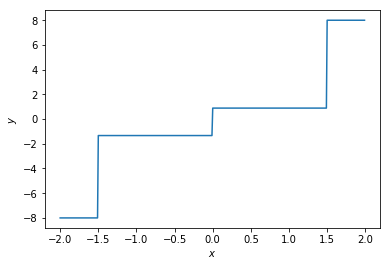

In [8]:
t=np.array([0, 1.5, -1.5])
X = np.linspace(-2, 2, 7)
y = X ** 3


def tree_fit(X, y, t):

    Xl = np.array([])
    Xll = np.array([])
    Xlr = np.array([])
    Xr = np.array([])
    Xrl = np.array([])
    Xrr = np.array([])

    yl = np.array([])
    yll = np.array([])
    ylr = np.array([])
    yr = np.array([])
    yrl = np.array([])
    yrr = np.array([])

    for i in range(len(X)):
        if X[i]<t[0]:
            Xl = np.append(Xl, X[i])
            yl = np.append(yl, y[i])
        else:
            Xr = np.append(Xr, X[i])
            yr = np.append(yr, y[i])

    for i in range(len(Xl)):
        if Xl[i]<t[2]:
            Xll = np.append(Xll, Xl[i])
            yll = np.append(yll, yl[i])
        else:
            Xlr = np.append(Xlr, Xl[i])
            ylr = np.append(ylr, yl[i])

    for i in range(len(Xr)):
        if Xr[i]<t[1]:
            Xrl = np.append(Xrl, Xr[i])
            yrl = np.append(yrl, yr[i])
        else:
            Xrr = np.append(Xrr, Xr[i])
            yrr = np.append(yrr, yr[i])

    return yll, ylr, yrl, yrr, t


def tree_predict(X_):
    ll, lr, rl, rr, t_ = tree_fit(X, y, t)
    y_=np.array([])

    for i in range(len(X_)):
        result = np.array([])
        if X_[i]<t_[0]:
            if X_[i]<t_[2]:
                result=np.append(result, ll)
            else:
                result=np.append(result, lr)
        else:
            if X_[i]<t_[1]:
                result=np.append(result, rl)
            else:
                result=np.append(result, rr)

        result = np.sum(result)/len(result)
        y_ = np.append(y_, result)

    return y_


X_test = np.arange(-2, 2, 0.01)
y_test = tree_predict(X_test)

plt.plot(X_test, y_test)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- **7**
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [22]:
df = pd.read_csv('mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [23]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [24]:
import math

df = pd.concat([df, pd.get_dummies(df['cholesterol'], 
                                               prefix="cholesterol"),
                      pd.get_dummies(df['gluc'], prefix="gluc")],
                     axis=1)
df.drop(['cholesterol', 'gluc'], 
             axis=1, inplace=True)

df['age_years'] = (df.age / 365.25).astype('int')

df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,age_years
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0,50
1,20228,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0,55
2,18857,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0,51
3,17623,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0,48
4,17474,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0,47


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [25]:
y = df.cardio
df.drop(['cardio'], axis=1, inplace=True)
X = df

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [26]:
import pydot
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\i.ashrapov\AppData\Local\Continuum\Anaconda3\pkgs\graphviz-2.38.0-4\Library\bin\graphviz'

tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

dot_data=export_graphviz(tree, out_file="hw2.dot", 
                feature_names=X_train.columns)

(graph,) = pydot.graph_from_dot_file("hw2.dot")
graph

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- **age, ap_hi, chol=3**

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [27]:
y_predict = tree.predict(X_valid)
accuracy_score(y_valid, y_predict)

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [28]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

Text(0,0.5,'Mean score')

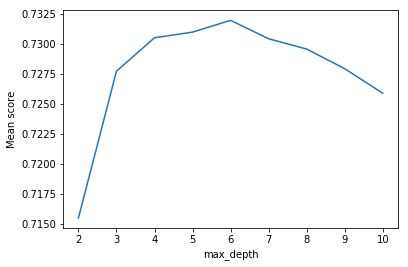

In [29]:
scores = [x for x in tree_grid.cv_results_['mean_test_score']]
plt.plot(tree_params['max_depth'], scores)
plt.xlabel('max_depth')
plt.ylabel('Mean score')

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [31]:
print(tree_grid.best_params_)
y_predict = tree_grid.predict(X_valid)
accuracy_score(y_valid, y_predict)

{'max_depth': 6}


0.72580952380952379

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- **да, нет**
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- ** Верхнее артериальное давление от 140 до 160 (мм рт.ст.) **
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [34]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,age_years
id,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,1,0,0,1,0,0,50
1,20228,1,156,85.0,140,90,0,0,1,0,0,1,1,0,0,55
2,18857,1,165,64.0,130,70,0,0,0,0,0,1,1,0,0,51
3,17623,2,169,82.0,150,100,0,0,1,1,0,0,1,0,0,48
4,17474,1,156,56.0,100,60,0,0,0,1,0,0,1,0,0,47


In [38]:
sub_df = pd.DataFrame(df.smoke.copy())
sub_df['male']  = df.gender - 1

sub_df['age_45_50'] = ((df.age_years >= 45) 
                       & (df.age_years < 50) ).astype('int')
sub_df['age_50_55'] = ((df.age_years >= 50) 
                       & (df.age_years < 55) ).astype('int')
sub_df['age_55_60'] = ((df.age_years >= 55) 
                       & (df.age_years < 60) ).astype('int')
sub_df['age_60_65'] = ((df.age_years >= 60) 
                       & (df.age_years < 65) ).astype('int')

sub_df['ap_hi_120_140'] = ((df.ap_hi >= 120) 
                           & (df.ap_hi < 140)).astype('int')
sub_df['ap_hi_140_160'] = ((df.ap_hi >= 140) 
                           & (df.ap_hi < 160)).astype('int')
sub_df['ap_hi_160_180'] = ((df.ap_hi >= 160) 
                           & (df.ap_hi < 180)).astype('int')

sub_df['chol=1'] = (df.cholesterol_1 == 1).astype('int')
sub_df['chol=2'] = (df.cholesterol_2 == 2).astype('int')
sub_df['chol=3'] = (df.cholesterol_3 == 3).astype('int')

In [40]:
tree = DecisionTreeClassifier(max_depth=3, 
                              random_state=17).fit(sub_df, y)

In [42]:
dot_data=export_graphviz(tree, out_file="hw3.dot", 
                feature_names=sub_df.columns)

(graph,) = pydot.graph_from_dot_file("hw3.dot")

In [43]:
graph.write_png("hw3.png")


True